<a href="https://colab.research.google.com/github/jfink09/Deep-Learning/blob/main/04_pytorch_video_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 04. PyTorch custom datasets video notebook:

Getting my own data into PyTorch via custom datasets

### 0.0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'1.12.1+cu113'

In [2]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1.0. Get data

The dataset is a subset of the Food101 set.

Food101 starts with 101 classes of food (750 training and 250 testing images).

Our dataset starts with 3 classes and only 10% of the images (~75 training and ~25 testing images).

In [3]:
import requests
import zipfile
from pathlib import Path

# Set up a path to a data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download.")
else:
  print(f"{image_path} does not exist...creating one")
  image_path.mkdir(parents=True,exist_ok=True)

# Download pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, and sushi data...")
  f.write(request.content)

# Unzip pizza, steak, and sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist...creating one
Unzipping pizza, steak, and sushi data...


### 2.0. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [5]:
# Set up train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 3.1. Visualizing an image

Write code to:

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata

data/pizza_steak_sushi/train/sushi/1571146.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/1571146.jpg
Image class: sushi
Image height: 384
Image width: 512


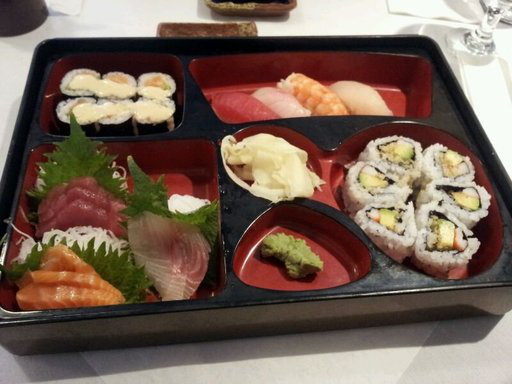

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

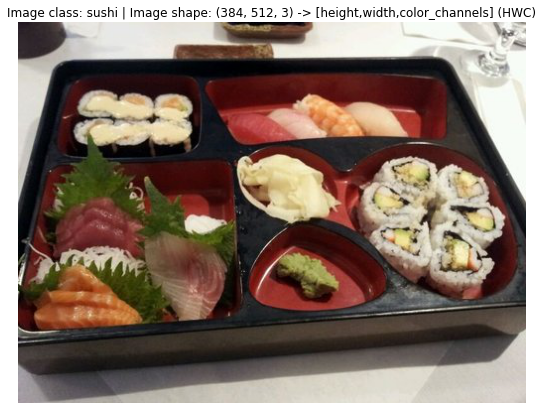

In [7]:
# Visualize with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channels] (HWC)")
plt.axis(False);

In [8]:
# Show the image in numerical format
img_as_array

array([[[ 36,  26,  35],
        [ 34,  24,  33],
        [ 33,  23,  32],
        ...,
        [146, 142, 133],
        [164, 160, 151],
        [176, 172, 161]],

       [[ 37,  27,  36],
        [ 36,  26,  35],
        [ 34,  24,  33],
        ...,
        [150, 147, 138],
        [149, 145, 136],
        [147, 143, 134]],

       [[ 39,  29,  38],
        [ 38,  28,  37],
        [ 37,  27,  36],
        ...,
        [185, 182, 173],
        [184, 180, 171],
        [181, 177, 168]],

       ...,

       [[158, 148, 156],
        [160, 150, 158],
        [164, 154, 162],
        ...,
        [204, 197, 191],
        [201, 194, 188],
        [198, 191, 185]],

       [[166, 156, 164],
        [167, 157, 165],
        [167, 157, 165],
        ...,
        [204, 197, 191],
        [199, 192, 186],
        [194, 187, 181]],

       [[166, 156, 164],
        [165, 155, 163],
        [164, 154, 162],
        ...,
        [203, 196, 190],
        [198, 191, 185],
        [192, 185, 179]]

### 3.0. Transforming data

Before we can use our image data with PyTorch:

1. Turn the target data into tensors (numerical representation of the images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` and we will call them `Dataset` and `DataLoader`

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1. Transforming data with `torchvision.transforms`

Transforms help get images ready to be used with model/perform data augmentation.

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize image to 64x64 since we used tiny VGG architecture
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.7922, 0.8510, 0.9255,  ..., 0.1922, 0.1647, 0.1490],
         [0.8706, 0.7765, 0.7059,  ..., 0.1922, 0.1765, 0.1725],
         [0.8863, 0.8235, 0.7098,  ..., 0.1843, 0.1804, 0.1843],
         ...,
         [0.8471, 0.8510, 0.8510,  ..., 0.5529, 0.6196, 0.6353],
         [0.8392, 0.8510, 0.8588,  ..., 0.6000, 0.6314, 0.6392],
         [0.8118, 0.8392, 0.8549,  ..., 0.6196, 0.6353, 0.6431]],

        [[0.7804, 0.8510, 0.9294,  ..., 0.1569, 0.1294, 0.1098],
         [0.8667, 0.7725, 0.6980,  ..., 0.1569, 0.1412, 0.1333],
         [0.8824, 0.8118, 0.6980,  ..., 0.1490, 0.1451, 0.1490],
         ...,
         [0.8196, 0.8235, 0.8235,  ..., 0.5333, 0.6000, 0.6118],
         [0.8118, 0.8235, 0.8314,  ..., 0.5765, 0.6039, 0.6118],
         [0.7843, 0.8118, 0.8275,  ..., 0.5961, 0.6039, 0.6039]],

        [[0.7490, 0.8235, 0.9137,  ..., 0.1686, 0.1490, 0.1451],
         [0.8353, 0.7529, 0.6824,  ..., 0.1725, 0.1569, 0.1608],
         [0.8549, 0.7922, 0.6745,  ..., 0.1725, 0.1608, 0.

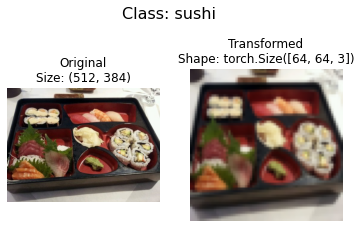

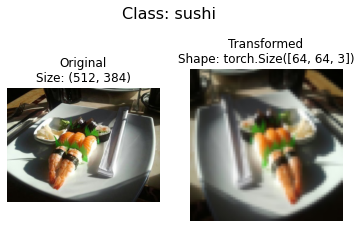

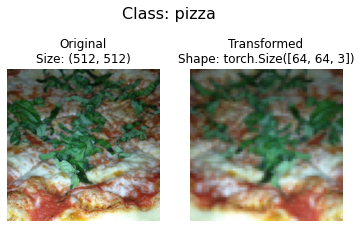

In [12]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs. the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot the target image
      transformed_image = transform(f).permute(1,2,0) # Will need to change the shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

### 4.0. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Class the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n {img}")
print(f"Image Shape:\n {img.shape}")
print(f"Image Datatype:\n {img.dtype}")
print(f"Image Label:\n {label}")
print(f"Label Datatype:\n {type(label)}")

Image Tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

In [20]:
class_names[label]

'pizza'

Original Shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image Permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

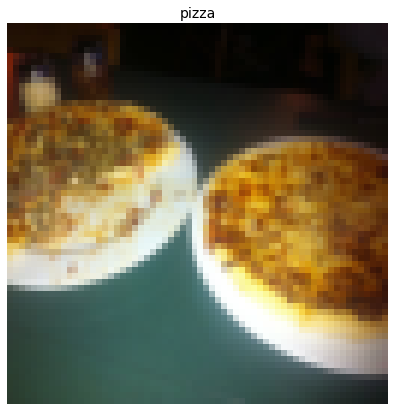

In [21]:
# Rearrange the other dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original Shape: {img.shape} -> [color_channels, height, width]")
print(f"Image Permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

### 4.1. Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [22]:
import os
os.cpu_count()

2

In [23]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7facf477c110>,
 <torch.utils.data.dataloader.DataLoader at 0x7facf477c0d0>)

In [24]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [25]:
len(train_data), len(test_data)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if wanted
print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([1])


### 5.0. Option 2: Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get class names as dictionary from Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it does not mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1. Creating a helper function to get class names

Make a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class names are not found (may be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them

In [32]:
# Set up path for target directory
target_directory = train_dir
print(f"Target Directory: {target_directory}")

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [33]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [38]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}... please check file structure.")
  
  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [40]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2. Create a custom `Dataset` to replicate `ImageFolder`

To create a custom dataset:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we want to get data from) as well as a transform if we want to transform the data
3. Create several attributes:
  * Paths - paths of the images
  * Transform - the transform we want to use
  * Classes - a list of our target classes
  * Class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()` to open images
5. Overwrite the `__len()__` method to return the length of the dataset
6. Overwrite the `__getitem()` method to return a given sample when passed an index

In [49]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize the custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Set up transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
    
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]
    
    # Transform inf necessary
    if self.transform:
      return self.transform(img), class_idx # Return data, label (X, y)
    else:
      return img, class_idx # Return untransformed image and label

In [50]:
# Create a transform
from torchvision.transforms import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [51]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [52]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7facf3161f90>,
 <__main__.ImageFolderCustom at 0x7facf3161990>)

In [53]:
len(train_data), len(train_data_custom)

(225, 225)

In [55]:
len(test_data), len(test_data_custom)

(75, 75)

In [56]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [57]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [59]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True
